In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import dsp_lib

In [2]:
def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

def downscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * (coeff)

In [3]:
file_path = "qpsk_rrc_float64.bin"
data_type = 'float64'

source_samples = dsp_lib.read_signal(file_path, data_type, 0, 0, '')


[[18232.84695497]
 [ 6581.29344813]
 [-3556.14850676]
 [12219.6844817 ]
 [24441.15854437]
 [ 8027.24977265]
 [-4354.35868324]
 [ 9673.55060162]
 [17891.71577304]
 [ 4834.73074919]]
[[18232.84695497]
 [ 6581.29344813]
 [-3556.14850676]
 [12219.6844817 ]
 [24441.15854437]
 [ 8027.24977265]
 [-4354.35868324]
 [ 9673.55060162]
 [17891.71577304]
 [ 4834.73074919]]


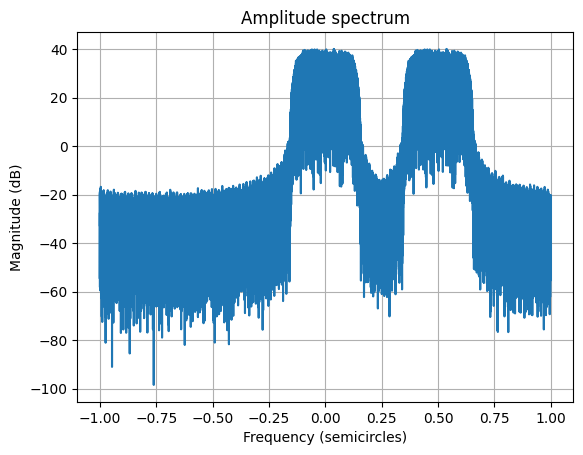

array([[-32.62366503],
       [-24.38116562],
       [-41.70106482],
       ...,
       [-28.66614247],
       [-20.13326012],
       [-26.33080639]])

In [4]:

dsp_lib.sum_double_val(8, 9)
dsp_lib.make_cmplx_sig(source_samples)

sig = dsp_lib.make_cmplx_sig(source_samples)
dsp_lib.plot_spectrum(sig, 0)

In [5]:
N = 129
Fs = 1
T_symb = 8
s_rrc = dsp_lib.gen_rrc_filter_impulse_response(N, Fs, T_symb)

[29793.13607291-77538.16395844j 46261.51778857-69438.2440201j
 58380.66403209-59952.19738737j 65365.34042472-49858.56194702j
 66933.83610452-39735.79574938j 63313.14013034-30195.256436j
 55431.3970878 -21806.97471046j 44699.70876769-14804.0922314j
 32539.69976653 -9161.34466198j 20258.82282751 -4892.08686734j]


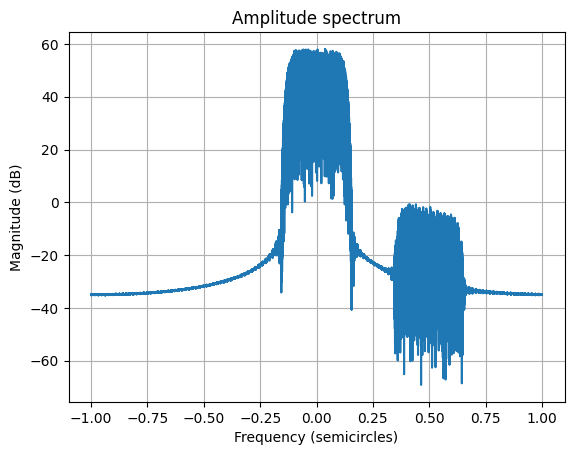

In [6]:
sig_rrc = np.convolve(sig, s_rrc, 'same')
print(sig_rrc[len(sig_rrc) - 10:])
dsp_lib.plot_spectrum(sig_rrc, 1)
dsp_lib.save_cmplx_sig(sig_rrc, "qpsk_rrc_after_py_rrc_fl64.bin", 'float64')

[29793.137-77538.164j  46261.523-69438.24j   58380.664-59952.203j
 65365.34 -49858.56j   66933.836-39735.797j  63313.14 -30195.254j
 55431.395-21806.977j  44699.707-14804.093j  32539.7   -9161.344j
 20258.822 -4892.0864j]


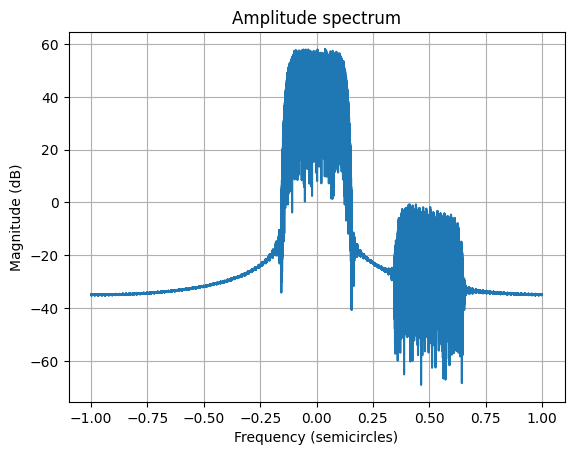

[-0.00527526 -0.00399103 -0.00164843  0.00129551]
[-0.00527526 -0.00399103 -0.00164843  0.00129551]
<class 'numpy.float64'>
9.253751671184363e-11


In [7]:
sig_fl32 = np.array(sig,  dtype=np.csingle)
s_rrc_fl32 = np.array(s_rrc, dtype = np.float32)
sig_rrc_fl32 = np.convolve(sig_fl32, s_rrc_fl32, 'same')
print(sig_rrc_fl32[len(sig_rrc_fl32) - 10:])
dsp_lib.save_cmplx_sig(sig_rrc_fl32, "qpsk_rrc_after_py_rrc_fl32.bin", data_type='float32')
dsp_lib.plot_spectrum(sig_rrc_fl32, 2)
print(s_rrc[:4])
print(s_rrc_fl32[:4])
print(type(s_rrc[0]))
print(s_rrc[0] - s_rrc_fl32[0])

In [8]:
sig_rrc_scaled = downscale_to_i16(sig_rrc)
max(sig_rrc_scaled)

(119098.3301216445-20080.12952850425j)
119098.3301216445
118852.8050103492
0.2751256039151219


(32766.999999999996-5524.5577632236045j)

In [9]:
max(sig_rrc)

(119098.3301216445-20080.12952850425j)

In [10]:
sig_rrc[-10:]

array([29793.13607291-77538.16395844j, 46261.51778857-69438.2440201j ,
       58380.66403209-59952.19738737j, 65365.34042472-49858.56194702j,
       66933.83610452-39735.79574938j, 63313.14013034-30195.256436j  ,
       55431.3970878 -21806.97471046j, 44699.70876769-14804.0922314j ,
       32539.69976653 -9161.34466198j, 20258.82282751 -4892.08686734j])

In [11]:
len(sig_rrc_fl32)

1032000